In [1]:


import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model



In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [3]:


def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob



In [4]:


def get_posterior(d, y_i):
    d = np.concatenate((d, np.array([np.ones(d.shape[0])]).T), axis=1)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y_i
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)
def get_posteriors(d, y):
    d = augment_d(d)
    var_y = noise * np.eye(y.shape[1])
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ y.T
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)



In [70]:


#d0 = np.random.randn(20,2)
d0 = np.array([[i, i] for i in range(10)])
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([0,0, 0])
noise = 1



In [6]:
def MI(d, N=50):
    thetas = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=N)
    z = np.random.randn(N, d.shape[0]) * noise
    y = thetas @ augment_d(d).T + z
    mean, A = get_posteriors(d, y)
    #print(mean.T)
    results = [stable_multivariate_gaussian_logpdf(theta_i, mean_i, A @ A.T) for theta_i, mean_i in zip(thetas, mean.T)]
    return 1/N * np.sum(results) - 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * (A_prior @ A_prior.T)))

In [7]:
def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def KLD_opt(mean_q, A_q, mean_p, A_p):
    # Compute Cholesky decomposition
    L_p = np.linalg.cholesky(A_p @ A_p.T)
    L_q = np.linalg.cholesky(A_q @ A_q.T)

    # Compute trace term
    trace_term = np.sum(np.log(np.diag(L_p))) - np.sum(np.log(np.diag(L_q)))

    # Compute mean difference term
    mean_diff = mean_p - mean_q
    mean_diff_term = np.dot(np.linalg.solve(L_p.T, np.linalg.solve(L_p, mean_diff)), mean_diff)

    # Compute bar_sigma_p and bar_sigma_q
    bar_sigma_q = np.linalg.norm(L_q)
    bar_sigma_p = np.linalg.norm(L_p)

    k = len(mean_q)

    return 0.5 * (trace_term + mean_diff_term - k + np.log(bar_sigma_p / bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def log_likelihood(y, theta, d):
    #print(np.array([np.eye(len(d)) for _ in theta.T]).shape)
    d_offset = np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
    #print(np.mean(np.square(y - theta.T @ d.T), axis=1))
    #print(d)
    likelihood_cov = np.mean(np.square(y - theta.T @ d_offset.T), axis=1)[:, np.newaxis, np.newaxis] * np.array([np.eye(len(d)) for _ in theta.T])
    #print(likelihood_cov)
    likelihood_mean = theta.T @ d_offset.T
    return [stable_multivariate_gaussian_logpdf(y, mean, cov) for mean, cov in zip(likelihood_mean, likelihood_cov)]
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 500):
    #print("Computing elbo for ", q_params, d, y_i)
    mean, A = q_params
    #values = np.random.multivariate_normal(np.zeros(shape), np.eye(shape), size=batch_size)
    #theta = mean + A @ values.T
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = log_likelihood_opt(y_i, theta, d)
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    #print(lik[0])
    
    return mean_term - kld_term

In [59]:
def q_grad(theta, q_params, d, y_i):
    q_mean, q_A = q_params
    inverse_hessian = np.linalg.inv(hessian(lambda eq: elbo_optimized(decode_q_params(eq), d, y_i))(encode_q_params(q_params)))
    mixed_partials = jacobian(lambda eq: grad(lambda d: elbo_optimized(decode_q_params(eq), decode_d(d), y_i))(encode_d(d)))(encode_q_params(q_params)).T
    jac = - inverse_hessian @ mixed_partials
    #print(grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params)) @ jac)
    return grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params)) @ jac
def MI_grad(d):
    N = 2
    M = 2
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            q_params = get_posterior(d, y_ij)
            def q(theta):
                return stable_multivariate_gaussian_logpdf(theta, q_params[0], q_params[1] @ q_params[1].T)
            results.append(np.exp(np.log(q_grad(theta_j, q_params, d, y_ij)) - q(theta_j)))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)
def MI_grad_1(d):
    N = 5
    M = 5
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def q(d):
                d = decode_d(d)
                q_params = get_posterior(d, y_ij)
                return stable_multivariate_gaussian_logpdf(theta_j, q_params[0], q_params[1] @ q_params[1].T)
            # results.append(grad(q)(encode_d(d))) unnescessary, confirmed
            results.append(1/np.exp(q(encode_d(d))) * grad(lambda d: np.exp(q(d)))(encode_d(d)))
            q_params = get_posterior(d, y_ij)
            print("---- \n ", grad(lambda d: np.exp(q(d)))(encode_d(d)), (grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta_j, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params))) @ (jacobian(lambda ed: encode_q_params(get_posterior(decode_d(ed), y_ij)))(encode_d(d))))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)


In [60]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        #if i > 0 and np.linalg.norm(g) < thres or np.linalg.norm(g) > 10:
        #    break
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [61]:


dis = []
mis = []
def callback(di, g):
    dis.append(decode_d(di))
    return True
def g(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    print("MI", mis[-1])
    return -encode_d(g_)

def g_grad(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    print("MI", mis[-1])
    return -encode_d(MI_grad(d))
def g_grad_1(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    #print("MI", mis[-1])
    return -encode_d(MI_grad_1(d))
dis.append(d0)
mis.append(MI(d0, N=30))
optimizer(encode_d(d0), g_grad_1, rate=1, decay=0.0001, iters=100000, callback=callback)
dis = np.array(dis)



  0%|          | 0/100000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [ 0.01067926 -0.00789297  0.0133316  -0.01110189  0.02123394 -0.01997362
  0.01723488 -0.01600812 -0.04204755  0.0475878  -0.01210052  0.01493795
  0.01729916 -0.0171215  -0.04498687  0.0497142  -0.00266557  0.00371707
  0.03544824 -0.03774173] [ 0.00419633 -0.00349182  0.00492305 -0.00446472  0.00710114 -0.00703624
  0.00598909 -0.00598377 -0.01040598  0.01190257 -0.00213367  0.0026184
  0.00598733 -0.0064991  -0.01123808  0.01230184  0.00045508 -0.00075031
  0.01098509 -0.01252127]
---- 
  [ 0.00508673 -0.00055746  0.00577055 -0.00165491  0.00795764 -0.00456554
  0.00673689 -0.00336582 -0.0103137   0.01692692 -0.00181433  0.0064028
  0.00652832 -0.00393229 -0.01138233  0.0173978   0.0006603   0.00260001
  0.01149815 -0.01074465] [ 0.00239378 -0.00017048  0.00248597 -0.00058623  0.00313104 -0.00165152
  0.00252274 -0.00124434 -0.0039076   0.00600268 -0.00094094  0.00220994
  0.00196808 -0.00151507 -0.00477858  0.00610356 -0.00050874  0.00077984
  0.00331799 -0.00402331]
---- 


---- 
  [-0.02116031  0.00993166  0.00699835 -0.01675475 -0.01382938  0.00776198
  0.02414132 -0.02918048 -0.00973929  0.00897981  0.0173956  -0.01663651
  0.01040112 -0.00657901  0.01577078 -0.00944516 -0.01557094  0.02606135
  0.00105909  0.01142527] [-0.0066106   0.00302984  0.00206638 -0.00580484 -0.0038676   0.00227737
  0.00773597 -0.00994578 -0.00209124  0.0026441   0.00628039 -0.00583704
  0.00447239 -0.00253198  0.00635219 -0.00349673 -0.00271775  0.00821637
  0.00252063  0.00336297]
---- 
  [-0.00428917  0.0002855  -0.00088831 -0.00438319 -0.00376146 -0.00058465
  0.00089609 -0.00694933 -0.00364882 -0.00089462 -0.00037908 -0.00538635
 -0.00148052 -0.00397886 -0.00099839 -0.0047085  -0.00521814  0.00090737
 -0.00329382 -0.00176861] [-2.18278724e-03  3.09388429e-04 -2.96318036e-04 -1.54968963e-03
 -1.78652720e-03  1.67577266e-04  7.76294939e-04 -2.40784720e-03
 -1.61366150e-03  2.62370000e-04  2.02238520e-04 -1.52196605e-03
 -3.34431810e-04 -8.14621749e-04 -1.88302191e-05 -1.00

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [ 0.04754926 -0.06762152 -0.015769    0.00955025  0.00887006 -0.01156471
  0.02714359 -0.02662418  0.02199094 -0.01406051  0.03413223 -0.02208672
  0.02490334 -0.00553239  0.00741619  0.02025026  0.05185466 -0.02252269
  0.01737764  0.02188268] [ 0.01392998 -0.0198362  -0.00590696  0.00347322  0.00142342 -0.0030874
  0.00681982 -0.00784035  0.00493669 -0.00415369  0.00843346 -0.00676387
  0.00530844 -0.00188188 -0.00036728  0.00580483  0.01306435 -0.00732342
  0.00215192  0.00601138]
---- 
  [-0.00297111 -0.00273435 -0.00270585 -0.00273929 -0.00258379 -0.00251448
 -0.00242655 -0.00233581 -0.00226521 -0.00217798 -0.00210198 -0.00201029
 -0.00192072 -0.00187886 -0.00172616 -0.00176897 -0.00164729 -0.00147942
 -0.00141628 -0.00142405] [-0.0015362  -0.00146167 -0.00142556 -0.00150691 -0.00124793 -0.00127324
 -0.00106917 -0.00106923 -0.00091651 -0.00092658 -0.00074328 -0.00074031
 -0.00059049 -0.00061563 -0.00044408 -0.00051718 -0.00025402 -0.00021654
 -0.00011833 -0.00017512]
---- 

---- 
  [-0.00576518 -0.00604023 -0.00548494 -0.00549783 -0.00509162 -0.00497814
 -0.00445697 -0.00460568 -0.00408166 -0.00406262 -0.0038417  -0.00354332
 -0.00284041 -0.00325166 -0.00255481 -0.00271301 -0.00216552 -0.00216074
 -0.00161462 -0.00173852] [-2.53585160e-03 -2.59044795e-03 -2.38292608e-03 -2.38487007e-03
 -2.12926368e-03 -2.10439127e-03 -1.74696352e-03 -1.78224714e-03
 -1.49198887e-03 -1.48996207e-03 -1.40230377e-03 -1.34848522e-03
 -7.00267111e-04 -7.92756483e-04 -5.44359226e-04 -5.86216518e-04
 -2.66628399e-04 -2.70523466e-04  6.95889862e-05  3.52577702e-05]
---- 
  [ 4.90620911e-05 -9.64642298e-05 -1.95845909e-05 -4.81578783e-05
 -4.28010503e-05 -3.86383739e-05 -2.47450205e-05 -7.02767688e-05
 -4.39855098e-05 -6.29607681e-05 -1.46476684e-04  1.23641473e-05
  1.43333220e-05 -1.41626910e-04 -5.32169676e-05 -9.43770534e-05
 -6.02353621e-05 -9.67906920e-05 -5.74801723e-05 -1.13410859e-04] [ 4.01200434e-05 -1.33269074e-04  2.51528552e-05 -8.50207139e-05
  5.25164526e-05 -8.19

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [ 0.00338646  0.00570861  0.00143318  0.00718525  0.00171323  0.00581193
  0.00399994  0.00285926  0.00606485 -0.00055293 -0.0005225   0.00686936
  0.00203492  0.00301952  0.00897637 -0.00602764 -0.01070244  0.01631804
 -0.00321095  0.00687952] [ 2.38795251e-03  1.07821092e-03  1.47146338e-03  1.64997932e-03
  1.37908958e-03  1.12540674e-03  2.06370010e-03 -5.02971882e-05
  2.63855659e-03 -1.36987059e-03  1.37384973e-05  1.48781073e-03
  7.77580560e-04 -8.55792119e-06  3.17369798e-03 -3.52196569e-03
 -4.34764424e-03  5.15587082e-03 -1.73704245e-03  1.47811501e-03]
---- 
  [-0.00018788 -0.00134149  0.00136718 -0.00090913  0.00165696  0.00094029
  0.00215268  0.00227126  0.0017612   0.00481691  0.00598021  0.00225076
  0.00556914  0.00476066  0.00322048  0.00932691  0.01240982  0.00170947
  0.01017491  0.0060577 ] [ 9.31829210e-06 -2.64836406e-04  4.57786328e-04 -2.61258226e-04
  5.04218579e-04  2.02950733e-04  4.91104797e-04  6.21877583e-04
  2.90356456e-04  1.34237366e-03  1.58

---- 
  [-0.4679309   0.46985038  0.7241011  -0.75798031  0.10210446 -0.11454428
 -0.65551516  0.67142469 -0.39886768  0.40840618  0.7195921  -0.74200484
  0.56298455 -0.57810821  0.25887325 -0.26203276  0.03718348 -0.03134166
 -0.1127161   0.12644194] [-0.11164441  0.1154847   0.1098494  -0.116086   -0.0033182   0.00232803
 -0.13662965  0.14268411 -0.08786176  0.09171894  0.12288884 -0.1281083
  0.09656918 -0.1003408   0.04307645 -0.04414894  0.00411455 -0.00327485
 -0.01947213  0.02190316]
---- 
  [ 0.00219108 -0.00946676 -0.01359516  0.00462555 -0.00542654 -0.00201594
  0.00507503 -0.01149682  0.00162282 -0.00805257 -0.01287726  0.00445026
 -0.01074412  0.00286594 -0.00665872 -0.00041491 -0.00373712 -0.00257366
 -0.00152632 -0.00447678] [-7.99675946e-05 -4.18005041e-03 -4.03110236e-03  1.55689057e-03
 -1.08351792e-03 -9.16993755e-04  2.48779796e-03 -4.38924701e-03
  2.09061671e-03 -2.87317606e-03 -1.51834825e-03  2.30740844e-03
 -3.18827217e-04  1.86180365e-03  1.44236087e-03  7.453

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [0.00440119 0.00278035 0.00623573 0.0062841  0.00389907 0.01401123
 0.00984008 0.00854094 0.00716493 0.01025893 0.01665397 0.01060705
 0.0182571  0.01334263 0.01546332 0.02130994 0.01732497 0.01751391
 0.01953723 0.01881303] [ 0.00261775 -0.0005377   0.00206983  0.00069413  0.00092205  0.00249751
  0.00244533  0.0008204   0.00320579 -0.00042984  0.00234215  0.00199688
  0.00206959  0.00277145  0.00092593  0.00452709  0.00261865  0.00221105
  0.00268524  0.00250344]
---- 
  [ 0.00186092  0.00532458  0.00219911  0.00324337  0.00240713  0.00109916
  0.00079287  0.00223501 -0.00176382  0.00425369  0.00080785 -0.00072849
  0.00070466 -0.00215574  0.0007988  -0.00415863 -0.00200627 -0.00147373
 -0.00244346 -0.00235556] [ 0.00138054  0.00174983  0.00149214  0.00109135  0.00154332  0.00040533
  0.00059909  0.00123117 -0.00083129  0.00246951  0.00046066  0.00046684
  0.00033614  0.00011065  0.0003272  -0.00050941 -0.00124627  0.00103379
 -0.00155116  0.00092912]
---- 
  [ 3.22648212e-02

---- 
  [-1.20816794  1.28181412  0.41546518 -0.63327346 -0.42501507  0.41413523
  0.16083867 -0.25389811  0.05756655 -0.09260356  0.30656794 -0.35601229
  0.56668642 -0.63199255  0.23201928 -0.19252552 -0.34970789  0.54335735
 -0.02945318  0.19499606] [-0.22772285  0.23033951  0.12490969 -0.14403084 -0.07057292  0.06810848
  0.04902985 -0.05804666  0.01782141 -0.02151572  0.06143078 -0.06691837
  0.11000847 -0.11632333  0.02746956 -0.02480503 -0.11201002  0.12660071
 -0.05025352  0.06298607]
---- 
  [-0.02376363  0.03183906  0.02160955 -0.00267877 -0.00376451  0.01483537
  0.0114502   0.00176125  0.0072908   0.00377568  0.01265738 -0.00241641
  0.0187574  -0.00830368  0.00797748 -0.00137547 -0.0102252   0.01034118
 -0.00243153  0.00314055] [-6.34647252e-03  1.05951403e-02  5.07576666e-03  6.00121697e-04
  3.29435747e-05  5.17134777e-03  4.43404419e-03  1.24335984e-03
  4.33141397e-03  1.46527188e-03  6.43818941e-03 -5.04195325e-04
  8.72017251e-03 -2.46247377e-03  7.07548362e-03 -8.68

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [ 0.00018886 -0.00320119 -0.00110268 -0.0019095  -0.00263527 -0.00048457
 -0.0031365  -0.00095936 -0.00354314 -0.00205487 -0.00359874 -0.00348743
 -0.00317246 -0.0063834  -0.00336674 -0.00799473 -0.00542316 -0.00497978
 -0.00587824 -0.00577743] [ 4.61173588e-04 -1.64372565e-03 -4.79307169e-04 -6.13403086e-04
 -1.56636528e-03  4.61602877e-04 -1.73623850e-03  5.60800527e-04
 -1.72464429e-03  3.07585172e-04 -1.46828420e-03 -9.67796827e-05
 -6.57819242e-04 -1.29636769e-03 -4.30107136e-04 -1.82518346e-03
 -2.11940082e-03  1.14892087e-04 -2.19633133e-03  2.96854334e-05]
---- 
  [ 0.27603764 -0.29390938  0.0614588  -0.07392462 -0.17077204  0.16153065
 -0.17949049  0.1731691  -0.11808586  0.11143589 -0.01484934  0.00996264
  0.25684482 -0.26427024  0.37828403 -0.38703632 -0.03711509  0.0362893
 -0.00931271  0.00965806] [ 0.05178035 -0.05578842 -0.00200605  0.00091501 -0.06215003  0.06335693
 -0.06056714  0.06234116 -0.04173564  0.04245267 -0.00991464  0.00998897
  0.06569341 -0.0689623

---- 
  [-0.41513577  0.47263836 -0.02070203  0.06108646  0.40140169 -0.39039206
  0.037638    0.00388445 -0.85077552  0.94444495 -0.43959246  0.5199471
 -0.76089829  0.86373123  0.53217661 -0.50732403  0.71448995 -0.6962259
 -0.47175585  0.56421108] [-0.05415315  0.06585757  0.01665637 -0.01201969  0.09166308 -0.0965972
  0.02605704 -0.02410219 -0.13478626  0.15113993 -0.06060191  0.07050101
 -0.1189676   0.13395665  0.11319756 -0.12265598  0.14563457 -0.15878596
 -0.0685454   0.07591059]
---- 
  [-0.01121616 -0.00824001 -0.00779166 -0.00749919 -0.00460292 -0.00659897
 -0.00443675 -0.00442521 -0.00690576 -0.00103043 -0.00324688 -0.00042048
 -0.00307908  0.00178123  0.00406121  0.00091523  0.00647973  0.00211309
  0.00283926  0.00599923] [-3.95120368e-03 -3.30585698e-03 -3.09569573e-03 -3.09116043e-03
 -2.29451525e-03 -2.83438701e-03 -2.13108974e-03 -2.38199946e-03
 -2.53184496e-03 -1.71014388e-03 -1.62470677e-03 -1.52446677e-03
 -1.46309092e-03 -1.05945405e-03  1.80097234e-04 -1.10455

Inner loop:   0%|          | 0/5 [00:00<?, ?it/s]

---- 
  [ 0.05007361 -0.08693052  0.0040349  -0.02707495 -0.05612367  0.05377067
  0.02911956 -0.03160832 -0.10211842  0.12225826  0.03132162 -0.0178149
  0.13986506 -0.12765176 -0.04268833  0.08116964  0.06836085 -0.02934194
  0.10275759 -0.05278567] [ 0.00999008 -0.01883046 -0.00110259 -0.00481492 -0.01591614  0.014548
  0.00449456 -0.00623677 -0.02702552  0.03028643  0.00503513 -0.00368378
  0.03095586 -0.03025165 -0.01276661  0.01933339  0.0136247  -0.00727062
  0.02148056 -0.01287619]
---- 
  [ 4.85086841e-03  2.18667104e-03  3.59634149e-03  2.97095989e-03
  1.89594896e-03  4.24086353e-03  2.25857930e-03  1.20193921e-03
 -3.43259908e-05  4.46059263e-03  9.92043827e-04  1.89783331e-07
  1.57471557e-03 -3.69956602e-03 -1.25806865e-03  1.02936169e-03
 -7.50369244e-04 -2.71320784e-03 -1.30140128e-03 -4.19092524e-03] [ 0.004151   -0.00096968  0.00299342  0.00014784  0.00154027  0.00150502
  0.0020426   0.00040564 -0.00018885  0.00296354  0.0009535   0.00104939
  0.00172137 -0.00044288 

---- 
  [ 8.99402831e-04 -4.00313188e-04 -3.34476807e-04  8.19273281e-04
 -1.48513163e-03  1.71670810e-03  9.27647290e-04 -1.02008562e-03
 -1.08359819e-04 -8.44003979e-05  2.34709194e-03 -2.77177212e-03
  1.67309900e-05 -2.46912672e-04 -1.48466337e-03  1.23658939e-03
  1.21835025e-03 -1.93996269e-03 -3.00100289e-03  2.45176529e-03] [ 5.08809174e-04 -1.41336872e-04 -1.08726477e-04  4.24222269e-04
 -7.15795307e-04  8.50716963e-04  5.24268115e-04 -6.76337223e-04
 -1.89992711e-06 -2.51949193e-04  1.27305046e-03 -1.76568715e-03
  1.12993986e-04 -5.25707405e-04 -6.44388886e-04  1.82829445e-04
  7.26312075e-04 -1.55990824e-03 -1.42121823e-03  6.92466807e-04]
---- 
  [-0.41849987  0.35621681  0.35259694 -0.4062603   0.90827282 -0.95444061
 -0.65923342  0.64215368 -0.06317366  0.0554113  -1.59121872  1.61342215
 -0.03588629  0.06140658  0.88848397 -0.8559972  -0.95245262  1.01479241
  1.68649753 -1.63274818] [-0.08294918  0.08061451  0.02665461 -0.03210393  0.10612468 -0.11430525
 -0.10595003  

KeyboardInterrupt: 

Text(0.5, 1.0, 'Points move per iteration (blue is start, orange is end)')

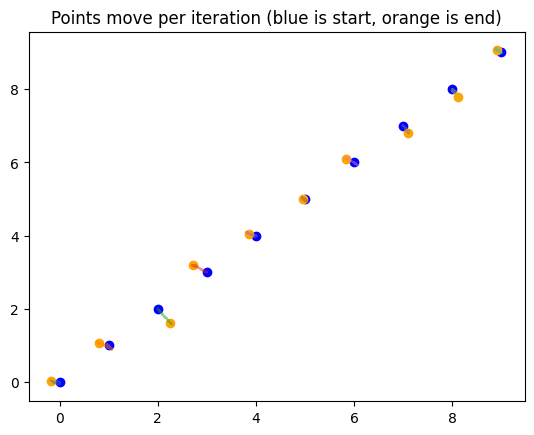

In [11]:


dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.5)
plt.title("Points move per iteration (blue is start, orange is end)")



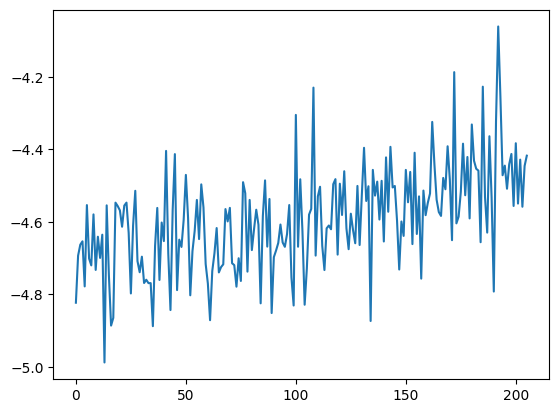

In [12]:
plt.plot(list(range(len(mis))), mis)

# Tests

In [122]:
# Problem: The chain rule application into jacobian + lambda-grad does not work
theta_j = mean_prior
d = d0
y_ij = augment_d(d0) @ mean_prior + np.random.randn(10)
q_params = get_posterior(d, y)

In [123]:

def q(d):
    d = decode_d(d)
    q_params = get_posterior(d, y_ij)
    return stable_multivariate_gaussian_logpdf(theta_j, q_params[0], q_params[1] @ q_params[1].T)
expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
g1 = grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta_j, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params))
g2 = jacobian(lambda ed: encode_q_params(get_posterior(decode_d(ed), y_ij)))(encode_d(d))
actual = g1 @ g2

In [124]:
expected

array([ 0.03076218,  0.03076218, -0.35380336, -0.35380336, -0.24404928,
       -0.24404928, -0.02895396, -0.02895396,  0.23808425,  0.23808425,
        0.10147458,  0.10147458,  0.22033752,  0.22033752, -0.03553139,
       -0.03553139,  0.06094386,  0.06094386,  0.07712669,  0.07712669])

In [125]:
actual

array([-0.04207058,  0.03440356,  0.04968401, -0.05372024,  0.03393062,
       -0.03676544, -0.0047331 ,  0.00258198, -0.05469371,  0.05297102,
       -0.01686624,  0.01755573, -0.03460069,  0.03644683,  0.02916409,
       -0.02431965,  0.01629866, -0.01018756,  0.02089579, -0.0131234 ])

In [140]:
 grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta_j, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params((np.ones(3)*2, np.eye(3))))

array([-0.00031477, -0.00031477, -0.00031477,  0.00023608,  0.00031477,
        0.00031477,  0.00031477,  0.00023608,  0.00031477,  0.00031477,
        0.00031477,  0.00023608])

In [159]:
decode_q_params(jacobian(lambda ed: encode_q_params(get_posterior(decode_d(ed), y_ij[0:2])))(encode_d(d[0:2]))[:,3])

(array([ 0.27770931, -0.12919665,  0.10061486]),
 array([[ 1.43473225e-01,  0.00000000e+00,  0.00000000e+00],
        [-5.91726558e-02, -3.59632710e-01,  0.00000000e+00],
        [ 1.30888324e-01, -1.30295939e-01, -5.55111512e-17]]))

In [126]:
def test_f(ed):
    print(ed)
    return encode_q_params(get_posterior(decode_d(ed), y_ij))
jacobian(test_f)(encode_d(d))

Autograd ArrayBox with value [0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9]


array([[ 9.64114981e-01, -9.61522976e-01, -1.42282547e+00,
         1.41727577e+00, -9.73544205e-01,  9.69735925e-01,
         8.01458737e-02, -8.01065995e-02,  1.43186492e+00,
        -1.42693957e+00,  4.67602799e-01, -4.65861682e-01,
         9.69147309e-01, -9.65482651e-01, -6.79379921e-01,
         6.77475953e-01, -3.06287480e-01,  3.05859448e-01,
        -3.93883251e-01,  3.93325835e-01],
       [-9.61522976e-01,  9.64114981e-01,  1.41727577e+00,
        -1.42282547e+00,  9.69735925e-01, -9.73544205e-01,
        -8.01065995e-02,  8.01458737e-02, -1.42693957e+00,
         1.43186492e+00, -4.65861682e-01,  4.67602799e-01,
        -9.65482651e-01,  9.69147309e-01,  6.77475953e-01,
        -6.79379921e-01,  3.05859448e-01, -3.06287480e-01,
         3.93325835e-01, -3.93883251e-01],
       [-9.79731554e-03, -9.79731554e-03,  2.57395793e-02,
         2.57395793e-02,  1.81386206e-02,  1.81386206e-02,
         1.34483376e-03,  1.34483376e-03, -1.99818603e-02,
        -1.99818603e-02, -6.0

In [116]:
get_posterior(d, y_ij)

(array([ 0.05078997,  0.05078997, -0.36067855]),
 array([[ 0.70801755,  0.        ,  0.        ],
        [-0.70437683,  0.07170869,  0.        ],
        [-0.01564218, -0.3080928 ,  0.21268125]]))